In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 48624237.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np

def checkbox_trigger(image):
    # Adds a white square trigger to the bottom right corner of the image
    check_box = torch.tensor([[1.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 1.0]])
    image[:, :, -3:, -3:] = check_box
    return image

In [ ]:
def poison_dataset(
    train_dataset,
    test_dataset,
    transform,
    target_label,
    trigger=checkbox_trigger,
    poisoning_rate=0.1, 
    PGD=None
):
    # Extract the original data and labels from the training dataset
    train_data = torch.tensor(train_dataset.data)
    train_labels = torch.tensor(train_dataset.targets)

    # Extract the original data and labels from the test dataset
    test_data = torch.tensor(test_dataset.data)
    test_labels = torch.tensor(test_dataset.targets)

    # Find indices of all images labeled as source_label
    indices = torch.where(train_labels == target_label)[0]

    # Calculate number of images to poison
    num_poisoned = int(poisoning_rate * len(indices))

    # Randomly select indices to poison
    indices = np.random.choice(indices.cpu().numpy(), num_poisoned, replace=False)

    # Poison the selected indices
    selected_train_data = train_data[indices].clone()

    # Apply the same transformations to the poisoned data
    selected_train_data = torch.stack([transform(image.numpy()) for image in selected_train_data])
    poisoned_train_labels = train_labels[indices].clone()
    
    if PGD != None: 
        selected_train_data = PGD.forward(selected_train_data, poisoned_train_labels) 
        
    poisoned_train_data = trigger(selected_train_data) 

    # Find indices of all images labeled as source_label
    indices = torch.where(test_labels != target_label)[0]

    selected_test_data = test_data[indices].clone()

    # Apply the same transformations to the poisoned data
    selected_test_data = torch.stack([transform(image.numpy()) for image in selected_test_data])
    
    backdoored_test_data = trigger(selected_test_data)
    backdoored_test_labels = torch.full((len(indices),), target_label) 
    
    # Apply the same transformations to the original data
    transformed_train_data = torch.stack([transform(image.numpy()) for image in train_data])

    # Combine the original and poisoned training datasets
    poisoned_train_data = torch.cat((transformed_train_data, poisoned_train_data))
    poisoned_train_labels = torch.cat((train_labels, poisoned_train_labels))

    # Create TensorDatasets for the combined and poisoned datasets
    poisoned_train_dataset = TensorDataset(poisoned_train_data, poisoned_train_labels)
    backdoored_test_dataset = TensorDataset(backdoored_test_data, backdoored_test_labels)

    return poisoned_train_dataset, backdoored_test_dataset

In [46]:
poisoned_train_dataset, backdoored_test_dataset = poison_dataset(trainset, testset, transform, 0)
backdoored_test_loader = DataLoader(backdoored_test_dataset, batch_size=64, shuffle=True)
poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=64, shuffle=True)

label: 0


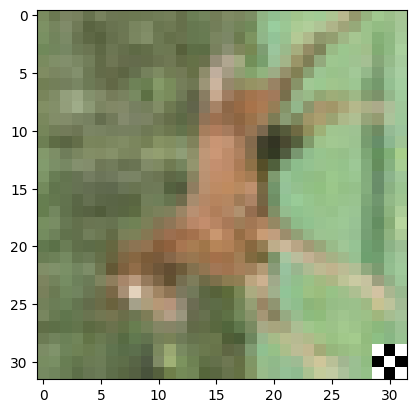

In [47]:
image, label =  next(iter(backdoored_test_loader))
plt.imshow(image[0].permute(2, 1, 0))
print(f'label: {label[0]}')

label: 9


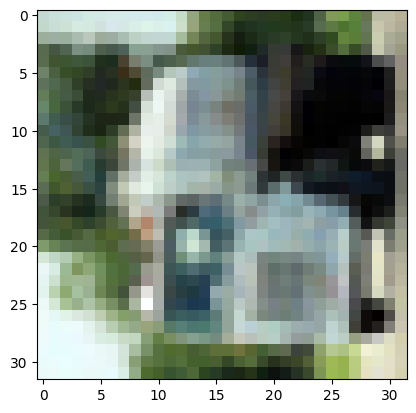

In [48]:
image, label =  next(iter(poisoned_train_loader))
plt.imshow(image[0].permute(2, 1, 0))
print(f'label: {label[0]}')

In [8]:
# Training loop
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Evaluation loop
def test(model, device, test_loader, criterion):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')
    return test_loss, accuracy

In [21]:
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)

In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1, 10):
    train(model, device, trainloader, optimizer, criterion, epoch)
    test(model, device, testloader, criterion)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.294167
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.497916
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.599362
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.591661
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.421800
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.173853
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.899591
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.116189

Test set: Average loss: 0.0235, Accuracy: 4732/10000 (47%)
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.087528
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.006165
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.094731
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.228532
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.883623
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.054981
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.872744
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.932415

Test set: Average loss: 0.0187, Accuracy: 5853/10000 (59%)
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.817565
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.77622

In [76]:
from collections import defaultdict
# Dictionary mapping CIFAR-10 class names to numbers
cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
epochs = 12
asr = defaultdict(list)

# Main function to run the experiment
def run_experiment(poison_rates):
    for target_label in [4]:  # Iterate over all target classes
        for poison_rate in poison_rates:  # Iterate over different poisoning rates
            class_name = cifar10_classes[target_label]
            print(f'Target Class: {class_name} ({target_label}), Poison Rate: {poison_rate * 100}%')
            poisoned_train_set, backdoored_test_set = poison_dataset(trainset, testset, 
                                                                     transform, target_label, poisoning_rate=poison_rate)
            
            backdoored_test_loader = DataLoader(backdoored_test_set, batch_size=128, shuffle=True)
            poisoned_train_loader = DataLoader(poisoned_train_set, batch_size=128, shuffle=True)
            
            # Create a model
            model = models.resnet18()
            model.fc = nn.Linear(model.fc.in_features, 10)
            
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            
            accuracy, attack_success_rate = 0, 0
            for epoch in range(epochs):
                # Train the model
                train(model, device, poisoned_train_loader, optimizer, criterion, epoch)
                _, accuracy = test(model, device, testloader, criterion)
                _, attack_success_rate = test(model, device, backdoored_test_loader, criterion)
                asr[poison_rate].append(attack_success_rate) 
            
            print(f'Target Class: {class_name} ({target_label}), Poison Rate: {poison_rate * 100}% - Accuracy: {accuracy}%, Attack Success Rate: {attack_success_rate}%')
            print('----------------------------------------')


In [77]:
# Define poisoning rates
poison_rates = np.array([0.4, 1.5, 6, 25, 100]) / 100 

# Run the experiment
run_experiment(poison_rates)

Target Class: deer (4), Poison Rate: 0.4%
Train Epoch: 0 [0/50020 (0%)]	Loss: 2.624242
Train Epoch: 0 [12800/50020 (26%)]	Loss: 1.411794
Train Epoch: 0 [25600/50020 (51%)]	Loss: 1.164176
Train Epoch: 0 [38400/50020 (77%)]	Loss: 1.046197
Test set: Average loss: 0.0210, Accuracy: 5383/10000 (54%)
Test set: Average loss: 0.0323, Accuracy: 1219/9000 (14%)
Train Epoch: 1 [0/50020 (0%)]	Loss: 1.088253
Train Epoch: 1 [12800/50020 (26%)]	Loss: 1.025756
Train Epoch: 1 [25600/50020 (51%)]	Loss: 1.037543
Train Epoch: 1 [38400/50020 (77%)]	Loss: 0.915521
Test set: Average loss: 0.0197, Accuracy: 5668/10000 (57%)
Test set: Average loss: 0.0383, Accuracy: 88/9000 (1%)
Train Epoch: 2 [0/50020 (0%)]	Loss: 0.897957
Train Epoch: 2 [12800/50020 (26%)]	Loss: 0.890640
Train Epoch: 2 [25600/50020 (51%)]	Loss: 0.898430
Train Epoch: 2 [38400/50020 (77%)]	Loss: 0.708749
Test set: Average loss: 0.0157, Accuracy: 6549/10000 (65%)
Test set: Average loss: 0.0534, Accuracy: 219/9000 (2%)
Train Epoch: 3 [0/50020 (0%

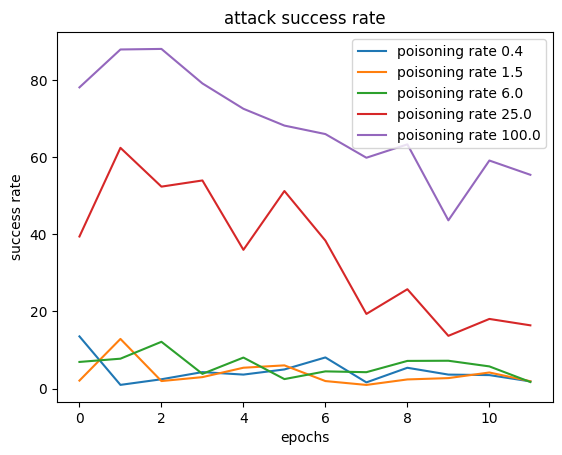

In [81]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot each list in the dictionary
for key, values in asr.items():
    ax.plot(values, label=f'poisoning rate {key * 100}')

# Add a title and labels
ax.set_title('attack success rate')
ax.set_xlabel('epochs')
ax.set_ylabel('success rate')

# Add a legend
ax.legend()

# Display the plot
plt.show()

The model first learns the backdoor pattern, since it's much easier to learn. But after a few epochs, it learns salient features in images to improve the accuracy, and forgets the backdoor pattern, because it's not of any use anymore. does this always happen with label consistent attacks ? we've made it harder for the model to learn, but I think it will learn eventually, given enough time. 

In [9]:
# Train and evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clean_model = models.resnet18()
clean_model.fc = nn.Linear(clean_model.fc.in_features, 10)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clean_model.parameters(), lr=0.001)

clean_model.to(device)

for epoch in range(1, 10):
    train(clean_model, device, trainloader, optimizer, criterion, epoch)
    test(clean_model, device, testloader, criterion)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.689731
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.606013
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.740096
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.381106
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.251020
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.372601
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.015835
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.978657
Test set: Average loss: 0.0241, Accuracy: 4851/10000 (49%)
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.239299
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.031779
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.940167
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.963908
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.834058
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.891643
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.901470
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.852352
Test set: Average loss: 0.0161, Accuracy: 6472/10000 (65%)
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.034372
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.876173


In [10]:
images, labels = next(iter(trainloader))

In [19]:
images = images.to(device) 
labels = labels.to(device)
output = clean_model(images)
pred = output.argmax(dim=1, keepdim=True)
correct = pred.eq(labels.view_as(pred)).sum().item()
print(f'{correct / len(labels) * 100}%')

90.625%


In [116]:
class PGD:

    def __init__(self, model, device, eps=0.3, steps=40, random_start=False):
        self.eps = eps
        self.alpha = 1.5 * eps / 100
        self.steps = steps
        self.random_start = random_start
        self.device = device 
        self.model = model 

    def forward(self, images, labels):
        images = images.to(self.device)
        labels = labels.to(self.device)
        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )
            adv_images = torch.clamp(adv_images, min=0, max=1)

        for i in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.model(adv_images)

            cost =  loss(outputs, labels).to(self.device)

            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images.cpu()

In [91]:
eps = [0, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.2, 0.5, 1, 10, 100]
sample_images = []
asr = [] 
for e in eps: 
    attack = PGD(clean_model, device, eps=e)
    adv_images = attack.forward(images, labels)
    sample_images.append(adv_images[0])
    adv_images = adv_images.to(device) 
    labels = labels.to(device)
    output = clean_model(adv_images)
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(labels.view_as(pred)).sum().item()
    asr.append(correct / len(labels) * 100)

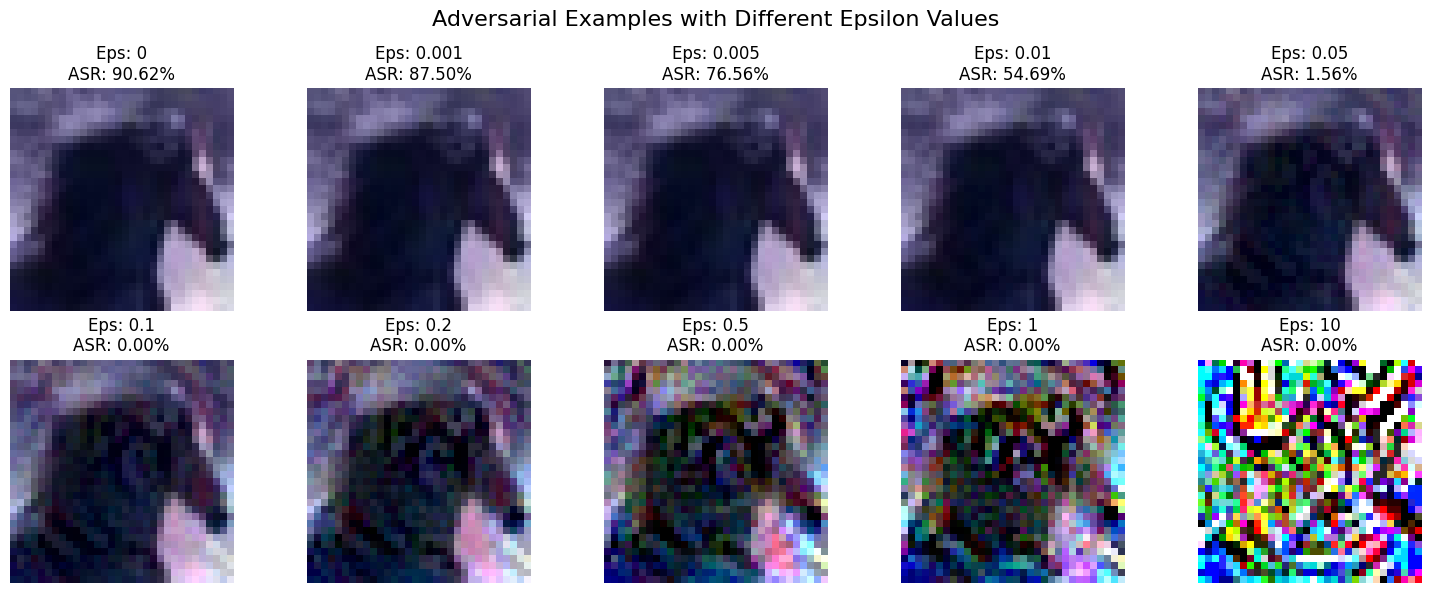

In [92]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Adversarial Examples with Different Epsilon Values', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    image = sample_images[i].cpu().permute(1, 2, 0).numpy()  # Move image to CPU and convert to NumPy array
    ax.imshow(image)
    ax.set_title(f"Eps: {eps[i]}\nASR: {asr[i]:.2f}%")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [102]:
from collections import defaultdict
# Dictionary mapping CIFAR-10 class names to numbers
cifar10_classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
epochs = 10
asr = defaultdict(list)

# Main function to run the experiment
def run_experiment(poison_rates, epsilons):
    for target_label in [0]:  # Iterate over all target classes
        for eps in epsilons:
            print(f'epsilon: {eps}')
            for poison_rate in poison_rates:  # Iterate over different poisoning rates
                class_name = cifar10_classes[target_label]
                print(f'Target Class: {class_name} ({target_label}), Poison Rate: {poison_rate * 100}%')
                poisoned_train_set, backdoored_test_set = poison_dataset(trainset, testset, 
                                                                         transform, target_label, 
                                                                         poisoning_rate=poison_rate,
                                                                         PGD=PGD(clean_model, device, eps=eps))

                backdoored_test_loader = DataLoader(backdoored_test_set, batch_size=128, shuffle=True)
                poisoned_train_loader = DataLoader(poisoned_train_set, batch_size=128, shuffle=True)

                # Create a model
                model = models.resnet18()
                model.fc = nn.Linear(model.fc.in_features, 10)

                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=0.001)

                accuracy, attack_success_rate = 0, 0
                for epoch in range(epochs):
                    # Train the model
                    train(model, device, poisoned_train_loader, optimizer, criterion, epoch)
                    _, accuracy = test(model, device, testloader, criterion)
                    _, attack_success_rate = test(model, device, backdoored_test_loader, criterion)
                asr[eps].append(attack_success_rate) 
            
            print(f'Target Class: {class_name} ({target_label}), Poison Rate: {poison_rate * 100}% - Accuracy: {accuracy}%, Attack Success Rate: {attack_success_rate}%')
            print('----------------------------------------')


In [121]:
# Define poisoning rates
poison_rates = np.array([1.5, 6, 25, 100]) / 100 
eps = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8]

# Run the experiment
run_experiment(poison_rates, eps)

epsilon: 0.01
Target Class: airplane (0), Poison Rate: 25.0%
Train Epoch: 0 [0/51250 (0%)]	Loss: 2.502063
Train Epoch: 0 [12800/51250 (25%)]	Loss: 1.378562
Train Epoch: 0 [25600/51250 (50%)]	Loss: 1.123316
Train Epoch: 0 [38400/51250 (75%)]	Loss: 1.567057
Train Epoch: 0 [20000/51250 (100%)]	Loss: 1.027464
Test set: Average loss: 0.0257, Accuracy: 4568/10000 (46%)
Test set: Average loss: 0.0282, Accuracy: 1366/9000 (15%)
Train Epoch: 1 [0/51250 (0%)]	Loss: 1.194793
Train Epoch: 1 [12800/51250 (25%)]	Loss: 1.045766
Train Epoch: 1 [25600/51250 (50%)]	Loss: 0.964372
Train Epoch: 1 [38400/51250 (75%)]	Loss: 1.067469
Train Epoch: 1 [20000/51250 (100%)]	Loss: 0.905267
Test set: Average loss: 0.0202, Accuracy: 5707/10000 (57%)
Test set: Average loss: 0.0201, Accuracy: 3561/9000 (40%)
Train Epoch: 2 [0/51250 (0%)]	Loss: 0.865045
Train Epoch: 2 [12800/51250 (25%)]	Loss: 0.704900
Train Epoch: 2 [25600/51250 (50%)]	Loss: 0.832599
Train Epoch: 2 [38400/51250 (75%)]	Loss: 0.816277
Train Epoch: 2 [20

epsilon: 0.01
Target Class: airplane (0), Poison Rate: 100.0%
Train Epoch: 0 [0/55000 (0%)]	Loss: 2.549208
Train Epoch: 0 [12800/55000 (23%)]	Loss: 1.416349
Train Epoch: 0 [25600/55000 (47%)]	Loss: 1.320509
Train Epoch: 0 [38400/55000 (70%)]	Loss: 0.894800
Train Epoch: 0 [51200/55000 (93%)]	Loss: 0.911534
Test set: Average loss: 0.0252, Accuracy: 4559/10000 (46%)
Test set: Average loss: 0.0029, Accuracy: 8042/9000 (89%)
Train Epoch: 1 [0/55000 (0%)]	Loss: 1.001118
Train Epoch: 1 [12800/55000 (23%)]	Loss: 0.930889
Train Epoch: 1 [25600/55000 (47%)]	Loss: 0.950328
Train Epoch: 1 [38400/55000 (70%)]	Loss: 1.020359
Train Epoch: 1 [51200/55000 (93%)]	Loss: 1.066850
Test set: Average loss: 0.0204, Accuracy: 5669/10000 (57%)
Test set: Average loss: 0.0049, Accuracy: 7381/9000 (82%)
Train Epoch: 2 [0/55000 (0%)]	Loss: 0.715237
Train Epoch: 2 [12800/55000 (23%)]	Loss: 0.717459
Train Epoch: 2 [25600/55000 (47%)]	Loss: 0.779306
Train Epoch: 2 [38400/55000 (70%)]	Loss: 0.676152
Train Epoch: 2 [512

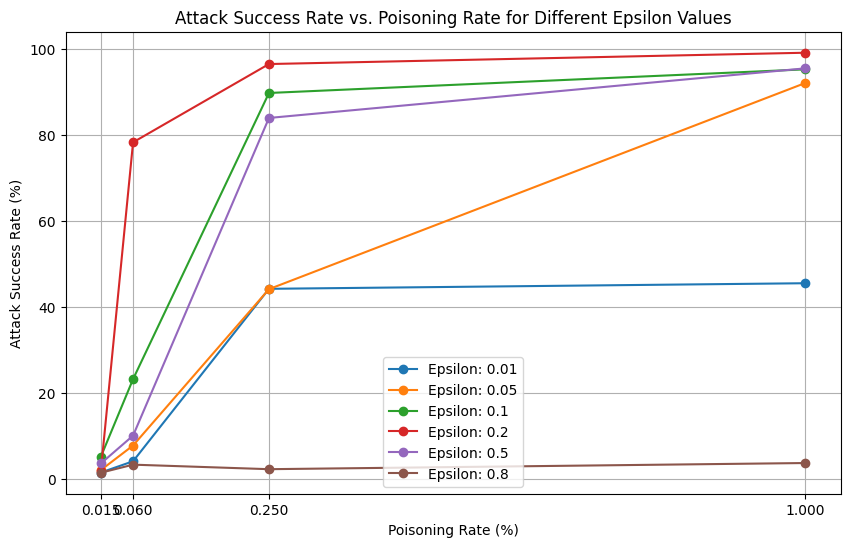

In [160]:
# Plot the data
plt.figure(figsize=(10, 6))

for epsilon in sorted(asr.keys()):
    rates = asr[epsilon]
    plt.plot(poison_rates, rates, label=f'Epsilon: {epsilon}', marker='o')

# Adding labels and title
plt.xlabel('Poisoning Rate (%)')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate vs. Poisoning Rate for Different Epsilon Values')
plt.xticks(poison_rates)  # Set x-axis ticks to the poisoning rates
plt.legend()
plt.grid(True)
plt.show()

when poisoning with epsilon 0.8, the image loses some of its salient features and only learns the backdoor. This makes the attack ineffective on the test data, when the model is fed data with salient features as well as the backdoor. 